In [1]:
import pandas as pd
import numpy as np
import operator
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression
import math

In [2]:
lime_results = pd.read_csv('lime_exp_01.csv')
shap_results = pd.read_csv('shap_exp_01.csv')
model_data = pd.read_csv('adult_model_data.csv')
model_data_display = pd.read_csv('adult_model_data_display.csv')

In [3]:
print(model_data_display.columns)
print(lime_results.columns)

Index(['Unnamed: 0', 'Age', 'Workclass', 'Education-Num', 'MaritalStatus',
       'Occupation', 'Relationship', 'Race', 'Sex', 'CapitalGain',
       'CapitalLoss', 'Hoursperweek', 'Country', 'income', 'prediction',
       'index'],
      dtype='object')
Index(['model', 'index', 'Age', 'Workclass', 'Education-Num', 'MaritalStatus',
       'Occupation', 'Relationship', 'Race', 'Sex', 'CapitalGain',
       'CapitalLoss', 'Hoursperweek', 'Country'],
      dtype='object')


(array([4951., 1562.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

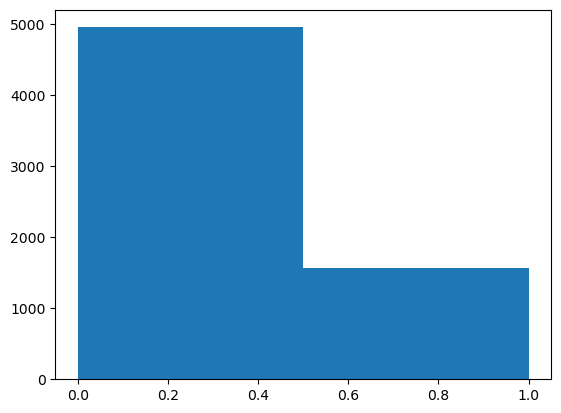

In [4]:
# print(np.var(model_data_display['CapitalGain'].values))
# print(np.std(model_data_display['CapitalGain'].values))
# print(np.percentile(model_data_display, 95))
# model_data_display['CapitalGain']
plt.hist(model_data_display['income'].values.astype(int), bins=2)

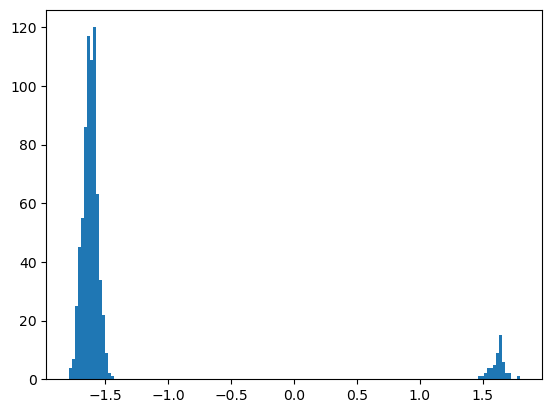

{'mean': -1.3977466826397158,
 'std': 0.8249094579402815,
 'variance': -0.590170928814081,
 'median': -1.6140543709249506,
 'mode*': -1.587127991522236,
 'importance': 1.6220294181773385}

In [5]:
def dataStats(model_data, explainer_data, header, values=None, operators=None, display=False, correct_pred=-1, headers=-1):
    filtered_data = model_data
    if header not in (model_data.columns):
        print(header, 'is not in the headers')
        return
    if not (operators == None and values == None):
        ops = {'==':operator.eq, '<=':operator.le, '>=':operator.ge, '!=':operator.ne, '>':operator.gt, '<':operator.lt}
        if type(operators) != list:
            operators = [operators]
        if type(values) != list:
            values = [values]
        for oper in operators:
            if oper not in ops.keys():
                print(operator, 'is not a valid operator')
                return
        if headers == -1:
            headers = [header] * len(values)
        if len(values)!=len(operators):
            print('number of values and operators are not equal')
            return

        for oper, value, h in zip(operators, values, headers):
            filtered_data = filtered_data[ops[oper](filtered_data[h], value)]
    if correct_pred == True:
        filtered_data = filtered_data[filtered_data['prediction'] == filtered_data['income']]
    if correct_pred == False:
        filtered_data = filtered_data[filtered_data['prediction'] != filtered_data['income']]
    
    indecies = filtered_data['index']
    filtered_exp = explainer_data[explainer_data['index'].isin(indecies)]
    filtered_exp_header = filtered_exp[header].values

    bins = max(min(len(filtered_exp_header),150),10)
    n,plt_bins,_ = plt.hist(filtered_exp_header,bins=bins)

    results = {}
    results['mean'] = np.mean(filtered_exp_header)
    results['std'] = np.std(filtered_exp_header)
    results['variance'] = results['std']/results['mean'] # WRONG needs updating
    results['median'] = np.median(filtered_exp_header)
    results['mode*'] = (plt_bins[n.argmax()]+plt_bins[n.argmax()+1])/2
    results['importance'] = np.mean(np.abs(filtered_exp_header))
    
    if (display == True):
        plt.show()
        
    return results

# print(lime_results['index'])
dataStats(model_data_display, lime_results, 'Age', values=35, operators='>', display=True, correct_pred=False)


In [6]:
def comparisonStats(model_data, exp_data1, exp_data2, header, values=None, operators=None, display=False, correct_pred=-1, headers=-1, percentile=0):
    filtered_data = model_data
    if header not in (model_data.columns):
        print(header, 'is not in the headers')
        return
    if not (operators == None and values == None):
        ops = {'==':operator.eq, '<=':operator.le, '>=':operator.ge, '!=':operator.ne, '>':operator.gt, '<':operator.lt}
        if type(operators) != list:
            operators = [operators]
        if type(values) != list:
            values = [values]
        for oper in operators:
            if oper not in ops.keys():
                print(operator, 'is not a valid operator')
                return
        if headers == -1:
            headers = [header] * len(values)
        if len(values)!=len(operators):
            print('number of values and operators are not equal')
            return

        for oper, value, h in zip(operators, values, headers):
            filtered_data = filtered_data[ops[oper](filtered_data[h], value)]
    if correct_pred == True:
        filtered_data = filtered_data[filtered_data['prediction'] == filtered_data['income']]
    if correct_pred == False:
        filtered_data = filtered_data[filtered_data['prediction'] != filtered_data['income']]
    
    indecies = filtered_data['index']
    filtered_exp1 = exp_data1[exp_data1['index'].isin(indecies)]
    f_exp1 = filtered_exp1[header].values
    filtered_exp2 = exp_data2[exp_data2['index'].isin(indecies)]
    f_exp2 = filtered_exp2[header].values
    exp_dif = f_exp1-f_exp2

    sample_size = len(f_exp1)
    bins = max(min(sample_size,150),10)
    dif_outliers = exp_dif[np.percentile(exp_dif,percentile)<=exp_dif]
    dif_outliers = dif_outliers[dif_outliers<=np.percentile(exp_dif,100-percentile)]
    n,plt_bins,_ = plt.hist(dif_outliers,bins=bins)

    dif_results = {}
    dif_results['mean'] = np.mean(exp_dif)
    dif_results['std'] = np.std(exp_dif)
    dif_results['variance'] = np.var(exp_dif)
    # dif_results['z-score'] = np.mean(stats.zscore(exp_dif))
    dif_results['median'] = np.median(exp_dif)
    dif_results['mode*'] = (plt_bins[n.argmax()]+plt_bins[n.argmax()+1])/2
    dif_results['importance'] = np.mean(np.abs(exp_dif))

    exp1_outliers = f_exp1[np.percentile(f_exp1,percentile)<=f_exp1]
    exp1_outliers = exp1_outliers[exp1_outliers<=np.percentile(f_exp1,100-percentile)]
    bin_index1,plt_bins1,_ = plt.hist(exp1_outliers,bins=bins)
    results1 = {}
    results1['mean'] = np.mean(f_exp1)
    results1['std'] = np.std(f_exp1)
    results1['variance'] = np.var(f_exp1)
    # results1['z-score'] = np.mean(stats.zscore(f_exp1))
    results1['median'] = np.median(f_exp1)
    results1['mode*'] = (plt_bins1[bin_index1.argmax()]+plt_bins1[bin_index1.argmax()+1])/2
    results1['importance'] = np.mean(np.abs(f_exp1))

    exp2_outliers = f_exp2[np.percentile(f_exp2,percentile)<=f_exp2]
    exp2_outliers = exp2_outliers[exp2_outliers<=np.percentile(f_exp2,100-percentile)]
    bin_index2,plt_bins2,_ = plt.hist(exp2_outliers,bins=bins)
    results2 = {}
    results2['mean'] = np.mean(f_exp2)
    results2['std'] = np.std(f_exp2)
    results2['variance'] = np.var(f_exp2)
    # results2['z-score'] = np.mean(stats.zscore(f_exp2))
    results2['median'] = np.median(f_exp2)
    results2['mode*'] = (plt_bins2[bin_index2.argmax()]+plt_bins2[bin_index2.argmax()+1])/2
    results2['importance'] = np.mean(np.abs(f_exp2))

    comp_results = {}
    comp_results['sign_match'] = np.mean((f_exp1>=0)==(f_exp2>=0)) # Both are the same
    comp_results['sign_pos'] = np.mean(np.all(np.stack(( ((f_exp1>=0)==1) , ((f_exp2>=0)==0) ), axis=0), axis=0)) # 1 is pos and 2 is neg
    comp_results['sign_neg'] = np.mean(np.all(np.stack(( ((f_exp1>=0)==0) , ((f_exp2>=0)==1) ), axis=0), axis=0)) # 1 is neg and 2 is pos
    comp_results['importance'] = np.mean(np.abs(f_exp1)) - np.mean(np.abs(f_exp2))
    comp_results['importance_sign_match'] = np.mean(((np.abs(f_exp1)-np.abs(f_exp2))[((f_exp1>=0)==(f_exp2>=0))])>0) # When Signs Match is A always more important
    comp_results['correlation'] = np.corrcoef(f_exp1, f_exp2)[0,1] # When A increases does B increase
    # comp_results['one-to-one'] = # measure of variance given a value
    bin_index1,plt_bins1,_ = plt.hist(exp1_outliers,bins=40)
    bin_hist1 = []
    for iter, i in enumerate(bin_index1.astype(int)):
        if iter<len(plt_bins1):
            bin_hist1.extend([plt_bins1[iter]]*i)
    trim_to = min(len(bin_hist1), len(exp2_outliers))
    bin_vals = defaultdict(list)
    for bin, y in zip(bin_hist1[:trim_to], exp2_outliers[:trim_to]):
        bin_vals[bin].append(y)
    total = []
    for values in bin_vals.values():
        std = stats.tstd(values)
        if len(values)>1:
            total.extend([std]*len(values))
    comp_results['inverse-correlation'] = np.mean(total) # Std of B within a bin of A

    linearModel = LinearRegression()
    linearModel.fit(exp1_outliers.reshape(-1,1), exp2_outliers)
    comp_results['slope'] = (linearModel.coef_)[0]
    p1 = np.array([0,linearModel.intercept_])
    p2 = np.array([1,linearModel.intercept_+comp_results['slope']])
    linear_distance = 0
    for p3 in np.stack((exp1_outliers, exp2_outliers), axis = 1):
        linear_distance += abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))
    comp_results['linear_distance'] = linear_distance/len(exp1_outliers)
    comp_results['sine_distance'] = abs(math.sin(math.atan((1-comp_results['slope'])/(1+comp_results['slope']))))
    mid_point = 1
    steepness = 3
    comp_results['normalized_distance'] = (1/(1+math.pow(math.e, -steepness*(comp_results['linear_distance']-mid_point))))
    comp_results['linear_disagreement'] = (comp_results['sine_distance']+(1/(1+math.pow(math.e, -steepness*(comp_results['linear_distance']-mid_point)))))/2


    results = {}
    results['difference'] = dif_results
    results[exp_data1['model'].values[0]] = results1
    results[exp_data2['model'].values[0]] = results2
    results['comparative'] = comp_results

    plt.close()
    if (display == True):
        # plt.hist(dif_outliers,bins=bins)
        plt.hist(exp1_outliers,bins=bins)
        plt.hist(exp2_outliers,bins=bins)
        plt.legend(['Difference',exp_data1['model'].values[0],exp_data2['model'].values[0]])
        plt.show()
        trim_to = min(len(exp1_outliers),len(exp2_outliers))
        plt.scatter(exp1_outliers[:trim_to], exp2_outliers[:trim_to], s=1)
        plt.xlabel(exp_data1['model'].values[0])
        plt.ylabel(exp_data2['model'].values[0])
        plt.show()
        mean_exp = (exp1_outliers+exp2_outliers)/2
        dif_exp = exp1_outliers-exp2_outliers
        plt.scatter(mean_exp[:trim_to], dif_exp[:trim_to], s=1)
        plt.xlabel('mean')
        plt.ylabel('difference')
        plt.show()
        
        # plt.scatter(bin_hist1[:trim_to], exp2_outliers[:trim_to], s=1)
        # plt.xlabel(exp_data1['model'].values[0])
        # plt.ylabel(exp_data2['model'].values[0])
        # plt.show()
        
    return results 

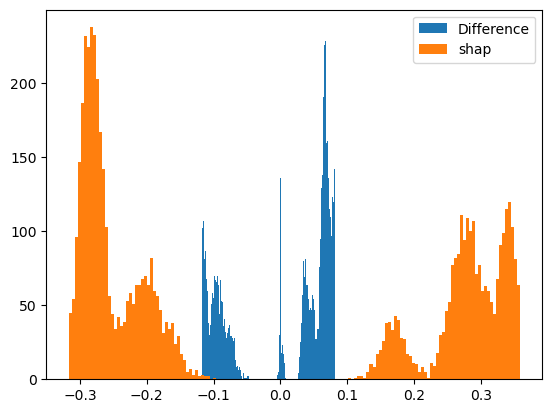

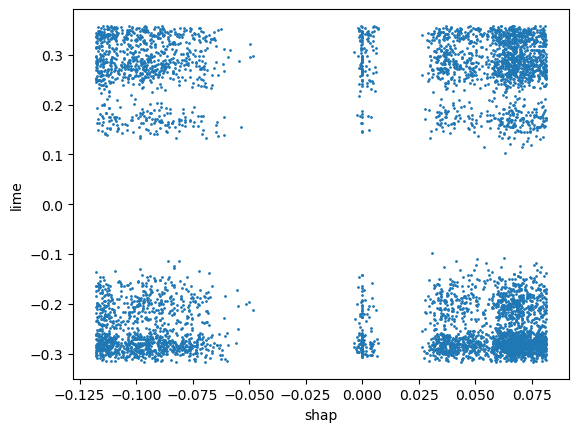

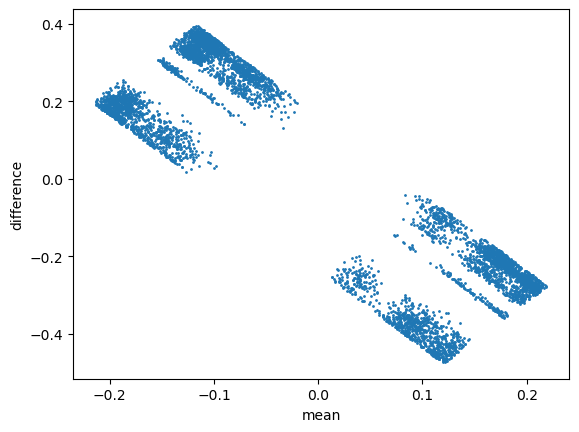

{'difference': {'mean': 0.023984785786065978, 'std': 0.26769886871904713, 'variance': 0.07166268431345763, 'median': 0.10533813422002111, 'mode*': 0.34409677869796945, 'importance': 0.2536336575542557}, 'shap': {'mean': 0.001976768233220139, 'std': 0.07865711559311805, 'variance': 0.006186941833429136, 'median': 0.0438223731241852, 'mode*': 0.06758468687352774, 'importance': 0.07367972775604607}, 'lime': {'mean': -0.022008017552845836, 'std': 0.2872378474541998, 'variance': 0.08250558101012213, 'median': -0.1877504612061739, 'mode*': -0.2828169922264059, 'importance': 0.279793714187731}, 'comparative': {'sign_match': 0.6416397973284201, 'sign_pos': 0.2745278673422386, 'sign_neg': 0.08383233532934131, 'importance': -0.20611398643168494, 'importance_sign_match': 0.000957166786312515, 'correlation': 0.3768780589933831, 'inverse-correlation': 0.26860903717706175, 'slope': -0.03399311250874325, 'linear_distance': 0.26159817294897353, 'sine_distance': 0.7307214775321434, 'normalized_distance

In [7]:
print(comparisonStats(model_data_display, shap_results, lime_results, 'MaritalStatus', display=True, percentile=5))

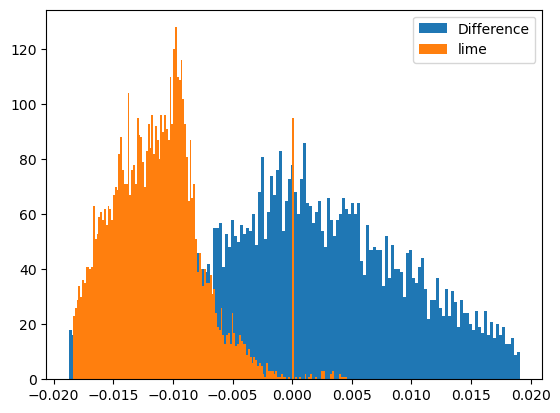

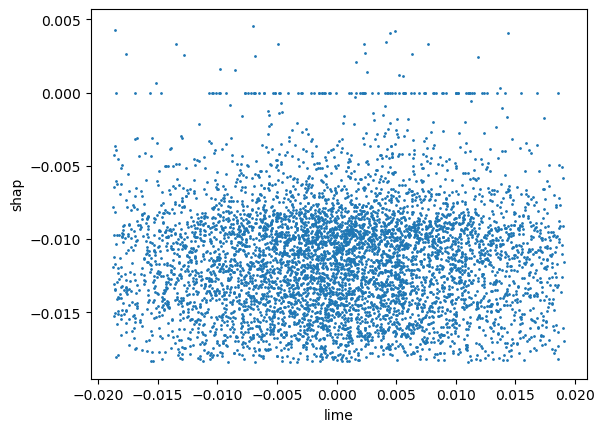

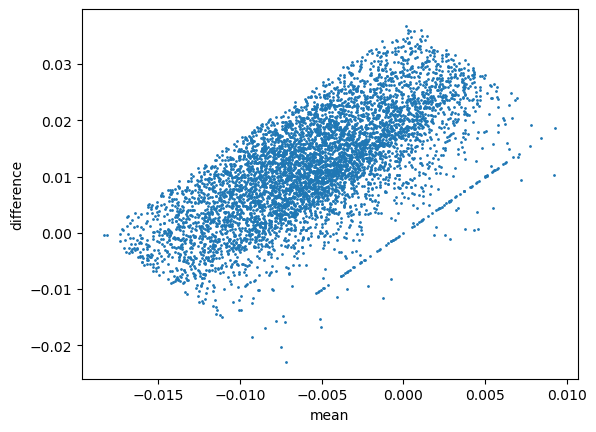

{'difference': {'mean': -0.0003621464160002511, 'std': 0.06120681256645401, 'variance': 0.0037462739045450327, 'median': 0.011466530103286299, 'mode*': 0.010109802218354183, 'importance': 0.025454999637296326}, 'lime': {'mean': 0.0003575094529676161, 'std': 0.01145460831912503, 'variance': 0.00013120805174456833, 'median': 0.0003484406328568, 'mode*': 0.0010667933780385136, 'importance': 0.008787992758196306}, 'shap': {'mean': 0.0007196558689678669, 'std': 0.06029990793193598, 'variance': 0.0036360788965999554, 'median': -0.0114032826520676, 'mode*': -0.009745189331356745, 'importance': 0.02316350608324197}, 'comparative': {'sign_match': 0.4891754951635191, 'sign_pos': 0.4779671426378013, 'sign_neg': 0.03285736219867957, 'importance': -0.014375513325045663, 'importance_sign_match': 0.2909604519774011, 'correlation': 0.015211151001679461, 'inverse-correlation': 0.0037679677537279166, 'slope': 0.00691201683266163, 'linear_distance': 0.0029661153799556087, 'sine_distance': 0.7022024732083

In [8]:
# 'Age', 'Workclass', 'Education-Num', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Sex', 'CapitalGain','CapitalLoss', 'Hoursperweek', 'Country'
# print(comparisonStats(model_data_display, lime_results, shap_results, 'Age', display=True, percentile=2))
# print(comparisonStats(model_data_display, shap_results, lime_results, 'MaritalStatus', display=False, percentile=5))
print(comparisonStats(model_data_display, lime_results, shap_results, 'CapitalLoss', display=True, percentile=5))

Goals:
Are they different?
How are they different?
Are there any patterns to how they are different

Individual analysis:
How is the explanations related to the inputs
How is the explanations related to the prediction


## Comparing Metrics
* Mean difference
* Standard Deviation difference
* Variance difference
* do the signs match?
* Which is consistantly larger
* Which is consistantly Important (Abs)
* Which is consistantly Smaller
* Do they agree (metrics)
* Do they disagree (metrics)
* Similarities between Inputs (Cross correlations)

## Individual Summaries
* When X is ... the importance is ~
* 

## Model Prediction in relation to explanation


\>50K, <=50K.

* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.